In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [6]:
#pip install split-folders

In [7]:
#import splitfolders

In [8]:
#input_folder='/content/drive/MyDrive/Colab Notebooks/TB_Dataset'

In [9]:
#splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Colab Notebooks/TB_Dataset12", seed=42, ratio=(.7,.2,.1), group_prefix=None)

In [10]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [11]:
# Training Data and Testing Data

train_path = '/content/drive/MyDrive/TB_Dataset/train'
valid_path = '/content/drive/MyDrive/TB_Dataset/test'

In [12]:
# add preprocessing layer to the front of VGG
# Here we will be using ImageNet weights, In this we are cutting First and last layer
# using include_top= False to create two class Parasited and Normal.

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [13]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# don't train existing weights

for layer in vgg.layers:
  layer.trainable = False

In [15]:
  # useful for getting number of classes
  # The output classes will be equal to no. of sub folders i.e. Parasited and Normal
  
folders = glob('/content/drive/MyDrive/TB_Dataset/train/*')
  

In [16]:
# We got classes Nomal and Tuberculosis
folders

['/content/drive/MyDrive/TB_Dataset/train/Normal',
 '/content/drive/MyDrive/TB_Dataset/train/Tuberculosis']

In [17]:
# our layers - you can add more if you want
# We flatten Layers except Last Layer
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)


In [18]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [19]:

# view the structure of the model
# You will be able to see the output layers as 3 and Dense layer added
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [21]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


In [23]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
# Make sure you provide the same target size as initialised for the image

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/TB_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')




Found 2937 images belonging to 2 classes.


In [25]:
training_set

In [26]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/TB_Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 421 images belonging to 2 classes.


In [27]:
#validation_data = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/TB_Dataset12/val',
                        #                    target_size = (224, 224),
                            #                batch_size = 32,
                            #                class_mode = 'categorical')

In [28]:
# This code snipet is used to detect undefined Image
import os
from PIL import Image
folder_path = '/content/drive/MyDrive/TB_Dataset/train'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])
    

In [31]:
# fit the model

r = model.fit(
    training_set,
    validation_data = test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/10
92/92 [==============================] - 194s 2s/step - loss: 0.0956 - accuracy: 0.9663 - val_loss: 0.0472 - val_accuracy: 0.9810
Epoch 2/10
92/92 [==============================] - 65s 709ms/step - loss: 0.0717 - accuracy: 0.9785 - val_loss: 0.0338 - val_accuracy: 0.9810
Epoch 3/10
92/92 [==============================] - 65s 709ms/step - loss: 0.0589 - accuracy: 0.9789 - val_loss: 0.0338 - val_accuracy: 0.9857
Epoch 4/10
92/92 [==============================] - 65s 710ms/step - loss: 0.0530 - accuracy: 0.9840 - val_loss: 0.0246 - val_accuracy: 0.9881
Epoch 5/10
92/92 [==============================] - 65s 711ms/step - loss: 0.0553 - accuracy: 0.9820 - val_loss: 0.0476 - val_accuracy: 0.9810
Epoch 6/10
92/92 [==============================] - 66s 713ms/step - loss: 0.0457 - accuracy: 0.9850 - val_loss: 0.0478 - val_accuracy: 0.9810
Epoch 7/10
92/92 [==============================] - 66s 712ms/step - loss: 0.0353 - accuracy: 0.9905 - val_loss: 0.0141 - val_accuracy: 0.9952
E

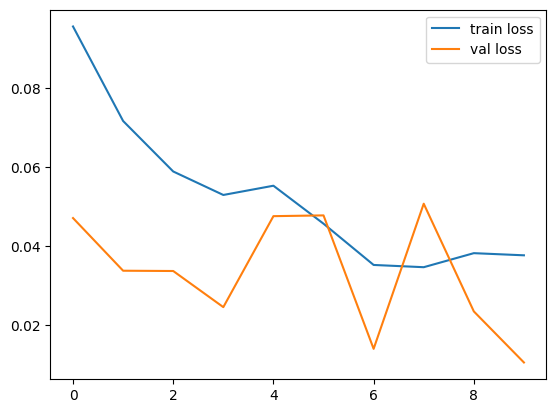

<Figure size 640x480 with 0 Axes>

In [32]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

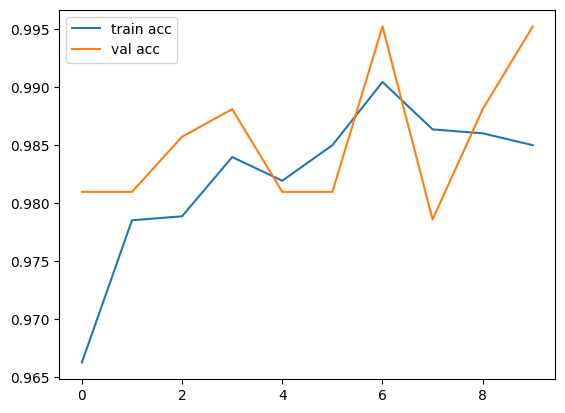

<Figure size 640x480 with 0 Axes>

In [33]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [41]:
import tensorflow as tf

from keras.models import load_model

model.save('/content/drive/MyDrive/Trained_Models/tuerculosis.h5')

In [42]:
y_pred=model.predict(test_set)


14/14 [==============================] - 5s 338ms/step


In [43]:
y_pred

array([[9.99996305e-01, 3.70797443e-06],
       [9.99251902e-01, 7.48070073e-04],
       [9.99981880e-01, 1.81342111e-05],
       [9.99998927e-01, 1.12971361e-06],
       [3.39826336e-04, 9.99660134e-01],
       [9.99993443e-01, 6.53702637e-06],
       [9.99959946e-01, 4.00875033e-05],
       [9.99869943e-01, 1.30033062e-04],
       [9.99830365e-01, 1.69595805e-04],
       [7.45030206e-07, 9.99999285e-01],
       [9.86267090e-01, 1.37328822e-02],
       [8.53441306e-04, 9.99146581e-01],
       [9.99929905e-01, 7.01160679e-05],
       [9.99620914e-01, 3.79050907e-04],
       [9.99915123e-01, 8.48352938e-05],
       [9.99913454e-01, 8.65631810e-05],
       [9.99995828e-01, 4.21496770e-06],
       [9.27588224e-01, 7.24118054e-02],
       [1.53204622e-02, 9.84679520e-01],
       [9.99986529e-01, 1.34459924e-05],
       [9.99999166e-01, 7.82272480e-07],
       [9.99971390e-01, 2.86684080e-05],
       [9.99993443e-01, 6.60247406e-06],
       [9.99992728e-01, 7.32768285e-06],
       [9.999783

In [44]:
import numpy as np
y_pred = np.argmax(y_pred,axis=0)

In [45]:
y_pred

array([137,  31])

In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image



In [47]:
model=load_model('/content/drive/MyDrive/Trained_Models/tuerculosis.h5')

In [60]:
# To Test the Model accuracy we took one Normal person X-ray image
# Let's see what will be the result

img=image.load_img('/content/drive/MyDrive/TB_Dataset/test/Normal/Normal-100.png',target_size=(224,224))

In [49]:
x=image.img_to_array(img)
x

array([[[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [ 9.,  9.,  9.]],

       [[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [ 9.,  9.,  9.],
        [ 9.,  9.,  9.],
        [10., 10., 10.]],

       [[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        ...,
        [ 9.,  9.,  9.],
        [ 9.,  9.,  9.],
        [ 8.,  8.,  8.]],

       ...,

       [[90., 90., 90.],
        [90., 90., 90.],
        [89., 89., 89.],
        ...,
        [33., 33., 33.],
        [58., 58., 58.],
        [39., 39., 39.]],

       [[92., 92., 92.],
        [87., 87., 87.],
        [88., 88., 88.],
        ...,
        [32., 32., 32.],
        [58., 58., 58.],
        [38., 38., 38.]],

       [[91., 91., 91.],
        [87., 87., 87.],
        [90., 90., 90.],
        ...,
        [32., 32., 32.],
        [54., 54., 54.],
        [36., 36., 36.]]

In [51]:
x.shape

(224, 224, 3)

In [52]:
x=x/255

In [53]:
x=np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [54]:
model.predict(img_data)

1/1 [==============================] - 1s 712ms/step


array([[2.4618257e-05, 9.9997532e-01]], dtype=float32)

In [58]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 25ms/step


In [61]:
if(a==1):
  print("Normal")
else:
  print("Tuerculosis")


Normal
